# Bőrrák többes klasszifikáció
(https://www.kaggle.com/datasets/francismon/curated-colon-dataset-for-deep-learning)

In [1]:
import sys, os, shutil, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *

# Only display errors
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import sklearn
from sklearn.metrics import *
import cv2
from sklearn.model_selection import train_test_split


In [2]:
# Setting up Kaggle API
# !pip install kaggle
# !mkdir ~/.kaggle
!cp '~/Downloads/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Downloading dataset
!kaggle datasets download -d vivek468/beginner-chest-xray-image-classification


  0%|          | 0.00/2.08G [00:00<?, ?B/s]
  0%|          | 1.00M/2.08G [00:00<07:03, 5.26MB/s]
  0%|          | 2.00M/2.08G [00:00<05:55, 6.27MB/s]
  0%|          | 3.00M/2.08G [00:00<05:31, 6.71MB/s]
  0%|          | 4.00M/2.08G [00:00<05:19, 6.96MB/s]
  0%|          | 5.00M/2.08G [00:00<05:13, 7.11MB/s]
  0%|          | 6.00M/2.08G [00:00<05:10, 7.17MB/s]
  0%|          | 7.00M/2.08G [00:01<05:09, 7.19MB/s]
  0%|          | 8.00M/2.08G [00:01<05:07, 7.24MB/s]
  0%|          | 9.00M/2.08G [00:01<05:05, 7.28MB/s]
  0%|          | 10.0M/2.08G [00:01<05:05, 7.28MB/s]
  1%|          | 11.0M/2.08G [00:01<05:04, 7.28MB/s]
  1%|          | 12.0M/2.08G [00:01<05:05, 7.26MB/s]
  1%|          | 13.0M/2.08G [00:01<05:03, 7.30MB/s]
  1%|          | 14.0M/2.08G [00:02<05:04, 7.28MB/s]
  1%|          | 15.0M/2.08G [00:02<05:06, 7.24MB/s]
  1%|          | 16.0M/2.08G [00:02<05:03, 7.29MB/s]
  1%|          | 17.0M/2.08G [00:02<05:02, 7.31MB/s]
  1%|          | 18.0M/2.08G [00:02<05:02, 7.31MB/s]
 

In [4]:
# Unzip it
!unzip vivek468/beginner-chest-xray-image-classification

'unzip' is not recognized as an internal or external command,
operable program or batch file.


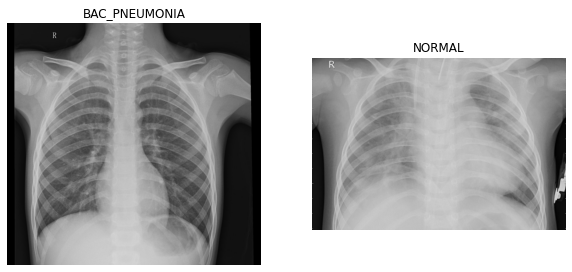

In [2]:
# Check some samples
plt.figure(figsize=(10,5))

ax = plt.subplot(1, 2, 1)
plt.imshow(keras.utils.load_img('chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg'))
plt.title('BAC_PNEUMONIA')
plt.axis('off')

ax = plt.subplot(1, 2, 2)
plt.imshow(keras.utils.load_img('chest_xray/test/PNEUMONIA/BACTERIA-1135262-0001.jpeg'))
plt.title('NORMAL')
plt.axis('off')

plt.show()


In [3]:
# Checking how imbalanced the classes are
class_lengths = str()
for i, path in enumerate(glob('train/*')):
    class_lengths += f"{i} : {len(glob(f'{path}/*'))} | "
    
print(class_lengths)

0 : 800 | 1 : 800 | 2 : 800 | 3 : 800 | 


In [4]:
# Two arrays holding images by class type
train_class0 = [] # 0 = normal
train_class1 = [] # 1 = pneumonia

test_class0 = [] # 0 = normal
test_class1 = [] # 1 = pneumonia

pred_class0 = [] # 0 = normal
pred_class1 = [] # 1 = pneumonia

# Filling the class arrays
for filename in glob('chest_xray/train/NORMAL/*.jpeg'):
    train_class0.append(filename)
for filename in glob('chest_xray/train/PNEUMONIA/*.jpeg'):
    train_class1.append(filename)

for filename in glob('chest_xray/test/NORMAL/*.jpeg'):
    test_class0.append(filename)
for filename in glob('chest_xray/test/PNEUMONIA/*.jpeg'):
    test_class1.append(filename)
    
for filename in glob('chest_xray/pred/NORMAL/*.jpeg'):
    pred_class0.append(filename)
for filename in glob('chest_xray/pred/PNEUMONIA/*.jpeg'):
    pred_class1.append(filename)

In [5]:
print(train_class0[0:10])

['chest_xray/train/NORMAL\\NORMAL_0.jpeg', 'chest_xray/train/NORMAL\\NORMAL_1.jpeg', 'chest_xray/train/NORMAL\\NORMAL_10.jpeg', 'chest_xray/train/NORMAL\\NORMAL_100.jpeg', 'chest_xray/train/NORMAL\\NORMAL_1000.jpeg', 'chest_xray/train/NORMAL\\NORMAL_1001.jpeg', 'chest_xray/train/NORMAL\\NORMAL_1002.jpeg', 'chest_xray/train/NORMAL\\NORMAL_1003.jpeg', 'chest_xray/train/NORMAL\\NORMAL_1004.jpeg', 'chest_xray/train/NORMAL\\NORMAL_1005.jpeg']


In [6]:
# Specify img size
IMAGE_SIZE = [200, 200]

# Return array full of images
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.jpeg'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_sized = cv2.resize(img_cvt, (IMAGE_SIZE[0],IMAGE_SIZE[1]), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [7]:
# Get the selected images to arrays
train_class0_array = get_image_arrays(train_class0, 0)
train_class1_array = get_image_arrays(train_class1, 1)

test_class0_array = get_image_arrays(test_class0, 0)
test_class1_array = get_image_arrays(test_class1, 1)

pred_class0_array = get_image_arrays(pred_class0, 0)
pred_class1_array = get_image_arrays(pred_class1, 1)

In [8]:
# Length of classes
print(len(train_class0_array))
print(len(train_class1_array))
print(len(test_class0_array))
print(len(test_class1_array))

3432
3883
234
386


In [9]:
# Combine the 4 arrays into one dataset
train = np.concatenate((train_class0_array, train_class1_array))
test = np.concatenate((test_class0_array, test_class1_array))
pred = np.concatenate((pred_class0_array, pred_class1_array))

random.seed(69)
random.shuffle(train)
random.shuffle(test)
random.shuffle(pred)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
# Data splitting
X_train = []
y_train = []

X_test = []
y_test = []

X_pred = []
y_pred = []

for features,label in train:
    X_train.append(features)
    y_train.append(label)
    
for features,label in test:
    X_test.append(features)
    y_test.append(label)
    
for features,label in pred:
    X_pred.append(features)
    y_pred.append(label)

X_train = np.array(X_train).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
X_test = np.array(X_test).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
X_pred = np.array(X_pred).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

In [11]:
# Converting to numpy arrays just in case
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_pred = np.array(X_pred)
y_pred = np.array(y_pred)

# Shapes of the arrays
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_test[0:200])

(7315, 200, 200, 3) (620, 200, 200, 3) (7315,) (620,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom((-0.2, -0.3), (-0.2, -0.3))
])

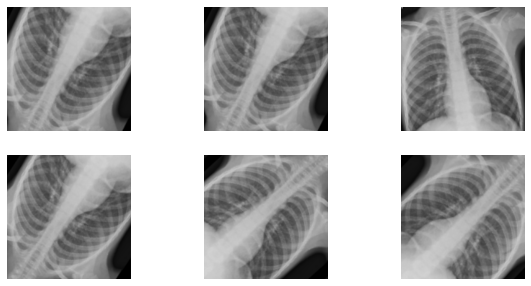

In [13]:
# Some augmented images
plt.figure(figsize=(10,5))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    augmented_img = data_augmentation(tf.expand_dims(X_test[0], 0))
    plt.imshow(augmented_img[0] / 255)
    plt.axis('off')

In [19]:
# Building the classification model
i = layers.Input(shape=IMAGE_SIZE + [3])
# Preprocessing
x = data_augmentation(i)
x = layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))(x)
# Processing
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.AveragePooling2D()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.AveragePooling2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.AveragePooling2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.AveragePooling2D()(x)
# Afterwork
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(2)(x) # bias_initializer=initializers.Constant(initial_bias)

model = keras.Model(i, x)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=
    [
        'accuracy'
    ])

In [56]:
# One hot encode the labels to solve shape issue
y_train = tf.one_hot(y_train, 1)
y_test = tf.one_hot(y_test, 1)

In [10]:
model.load_weights('weights/cis-11-10')

In [20]:
r = model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=8,
        # class_weight=class_weight,
        callbacks=[       
            tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            patience=5,
                                            verbose=1,
                                            restore_best_weights=True
                                            )
        ]
    )

Epoch 1/10
915/915 [==============================] - 623s 679ms/step - loss: 0.4776 - accuracy: 0.8261 - val_loss: 0.5637 - val_accuracy: 0.7565
Epoch 2/10
915/915 [==============================] - 618s 675ms/step - loss: 0.4729 - accuracy: 0.8269 - val_loss: 0.5796 - val_accuracy: 0.7565
Epoch 3/10
915/915 [==============================] - 629s 688ms/step - loss: 0.4633 - accuracy: 0.8269 - val_loss: 0.5660 - val_accuracy: 0.7565
Epoch 4/10
915/915 [==============================] - 582s 636ms/step - loss: 0.4650 - accuracy: 0.8265 - val_loss: 0.5728 - val_accuracy: 0.7565
Epoch 5/10
915/915 [==============================] - 597s 653ms/step - loss: 0.4632 - accuracy: 0.8269 - val_loss: 0.5679 - val_accuracy: 0.7565
Epoch 6/10
915/915 [==============================] - 613s 669ms/step - loss: 0.4627 - accuracy: 0.8269 - val_loss: 0.5699 - val_accuracy: 0.7565
Epoch 6: early stopping


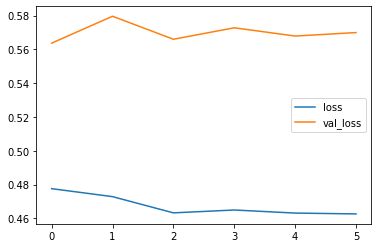

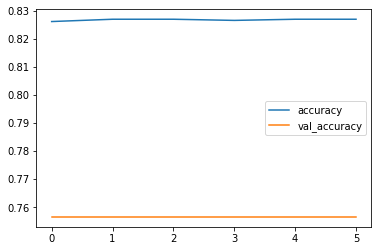

In [23]:
# Plotting the model loss to see the results
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Plotting the model accuracy to see the results
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [32]:
# Evaluate
model.evaluate(X_pred, y_pred)

1/1 [==============================] - 0s 256ms/step - loss: 0.4980 - accuracy: 0.7778


[0.4979947507381439, 0.7777777910232544]

In [33]:
# Prediction
Y_pred = model.predict(X_pred)
Y_pred

1/1 [==============================] - 0s 190ms/step


array([[ 0.9218757 , -0.8862283 ],
       [ 0.76496065, -0.71740234],
       [ 0.76496065, -0.71740234],
       [ 0.7501062 , -0.7025275 ],
       [ 0.9218757 , -0.8862283 ],
       [ 0.9218757 , -0.8862283 ],
       [ 0.7129378 , -0.66186523],
       [ 0.71597195, -0.66533744],
       [ 0.77299976, -0.72807384]], dtype=float32)

In [26]:
# Save class weights bc we need to configure the dataset bc of imbalance
model.save_weights('weights/cis_beginner_12-03')